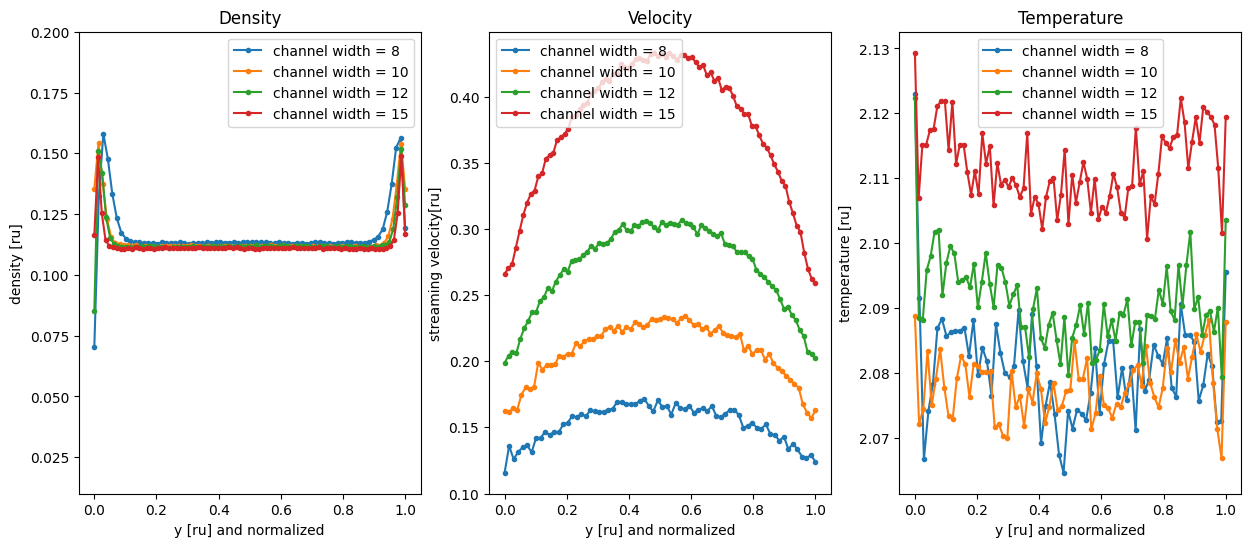

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

#Function to somewhat clean up the spiking action going on at the walls, only used for velocity
def cleanSpikes(arr,diff,replace):
    newz = []
    for i,coord in enumerate(arr):
        if(i==0):
            newz.append(coord)
            continue
        if(np.abs(coord-newz[-1]) > diff or coord<0):
            newz.append(replace)
        else: newz.append(coord)
    return newz

def getTable(file):
    table = pd.read_csv(file,delimiter=" ",header=None,names=["pos_z","density","velocity","temperature"])
    wall_mask = table["density"] > 0.07
    table["pos_z"] = table["pos_z"][wall_mask]
    table["density"] = table["density"][wall_mask]
    table["velocity"] = table["velocity"][wall_mask]
    table["temperature"] = table["temperature"][wall_mask]

    table["pos_z"] =  table["pos_z"] - table["pos_z"].min()
    return table

def plot(ax,file,lbl):
    table = getTable(f'../Tests/{file}.dat')
    ax[0].plot(table["pos_z"]/table["pos_z"].max(),table["density"],label=lbl,marker=".")
    ax[0].set_title("Density")
    # ax[0].set_ylim(0.4,0.52)
    ax[0].set_ylim(0.01,0.2)
    ax[0].set_xlabel("y [ru] and normalized")
    ax[0].set_ylabel("density [ru]")
    ax[0].legend()

    ax[1].plot(table["pos_z"]/table["pos_z"].max(),table["velocity"],label=lbl,marker=".")
    ax[1].set_title("Velocity")
    ax[1].set_xlabel("y [ru] and normalized")
    ax[1].set_ylabel("streaming velocity[ru]")
    ax[1].legend()

    ax[2].plot(table["pos_z"]/table["pos_z"].max(),table["temperature"],label=lbl,marker=".")
    ax[2].set_title("Temperature")
    ax[2].set_xlabel("y [ru] and normalized")
    ax[2].set_ylabel("temperature [ru]")
    ax[2].legend()

fig,ax = plt.subplots(1,3,sharex=False,figsize=(15,6))

# plot(ax,"WG9","channel width = 5")
# plot(ax,"WG8","channel width = 8")
# plot(ax,"WG1","channel width = 10")
# plot(ax,"WG2","channel width = 12")
# plot(ax,"WG3","channel width = 15")
# plot(ax,"WG4","Pressure=0.03")
# plot(ax,"WG5","Pressure=0.05")
# plot(ax,"WG6","Pressure=0.08")
# plot(ax,"WG7","Pressure=0.1")

plot(ax,"WAu8","channel width = 8")
plot(ax,"WAu1","channel width = 10")
plot(ax,"WAu2","channel width = 12")
plot(ax,"WAu3","channel width = 15")
# plot(ax,"WAu4","Pressure=0.03")
# plot(ax,"WAu5","Pressure=0.05")
# plot(ax,"WAu6","Pressure=0.08")
# plot(ax,"WAu7","Pressure=0.1")


In [ ]:
def parabola(x,a,b,c):
    return x**2*a+x*b+c

def findSlipLengthCF(x,y,estimate_center,estimate_B):
    vars,cov=curve_fit(parabola,x,y,[-1/(2*estimate_center),-estimate_center*2,estimate_B],absolute_sigma=True)
    L_s = -vars[2]/vars[1]
    return np.abs(L_s),vars[0],vars[1],vars[2]

